# NGSeminar: Introduction to biostatistics (with Python)

**Urszula Smyczyńska**

**30.07.2020**

# Initial settings

## Check if working in Colab and install needed modules

Shutting kernel down from code may produce a prompt about problem with notebook session in Colab, but don't worry it'll restart and we need it to import new modules properly.

In [1]:
import sys
import IPython

IN_COLAB = 'google.colab' in sys.modules
print(IN_COLAB)

if IN_COLAB:
    !pip install scikit-posthocs
    !pip install --upgrade scipy
    IPython.Application.instance().kernel.do_shutdown(True)

False


## Import needed modules

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format
import matplotlib.pyplot as plt
from scipy import stats
import scikit_posthocs as posthocs
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
import itertools
import seaborn as sns
import sys

IN_COLAB = 'google.colab' in sys.modules

# Read *HCV_Data_Germany_ngseminar* dataset

It contains data of patients with HCV and healthy people (blood donor).

[Dataset](http://archive.ics.uci.edu/ml/datasets/HCV+data) was downloaded from UCI [Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/HCV+data).

It was slightly modified by me for this seminar :).

It contains following variables:
* **Category** (nominal): 
    * Blood Donor
    * Fibrosis
    * Cirrhosis - very advanced, late fibrosis
    * Hepatitis - inflammation of liver tissue.
* **Healthy** (nominal, that's what I added to have nominal variables with 2 groups):
    * YES - for Category: Blood Donor
    * NO - for all other case
* **Age** (continuous, but here it is rounded to integers)
* **Sex** (nominal): 
    * m - man
    * f - woman
* **ALB** (continuous) - albumin. Albumins are globular, water-soluble proteins, commonly found in blood plasma.
* **ALP** (continuous) - alkaline phosphatase; dephosphorylating enzyme, elevated levels of ALP are often found in patients with liver disease.
* **ALT** (continuous) - alanine amino-transferase, alanine transaminase; enzyme involved in amino acids metabolism. Elevated ALT indicates health problems, often with liver (hepatitis, liver damage, bile duct problems).
* **AST** (continuous) - aspartate amino-transferase, aspartate transaminase; enzyme involved in amino acids metabolism. Used to assess liver function, also together with ALT as AST/ALT ratio.
* **BIL** (continuous) - bilirubin; metabolite produced as a result of breakdown of aged or abnormal red blood cells. It is responsible for yellow discoloration in jaundice. Elevated in patients with hepatitis.
* **CHE** (continuous) - choline esterase; an enzyme. One of its types is produced mainly in liver and it may be lower in patients liver disease.
* **CHOL** (continuous) - cholesterol.
* **CREA** (continuous) - creatinine; metabolite, produced by muscle metabolism, used as marker of kidney function.
* **GGT** (continuous) - gamma-glutamyl transferase; an enzyme involved, among the others, in xenobiotic detoxification. GGT is elevated in patients with liver disease (or after excess alcohol consumption).
* **PROT** (continuous) - total protein.

We will use only some of them, but explanation for all doesn't harm.

In [3]:
if IN_COLAB:
    fname = 'https://raw.githubusercontent.com/UlaSmycz/NGSeminar_biostatistics/master/HCV_Data_Germany_ngseminar.csv'
else:
    fname = 'HCV_Data_Germany_ngseminar.csv'

hcvDataG = pd.read_csv(fname, header = 0, index_col = 0)

display(hcvDataG)

,Category,Healthy,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
ID,,,,,,,,,,,,,,
1,Blood Donor,YES,32,m,38.5000,52.5000,7.7000,22.1000,7.5000,6.9300,3.2300,106.0000,12.1000,69.0000
2,Blood Donor,YES,32,m,38.5000,70.3000,18.0000,24.7000,3.9000,11.1700,4.8000,74.0000,15.6000,76.5000
3,Blood Donor,YES,32,m,46.9000,74.7000,36.2000,52.6000,6.1000,8.8400,5.2000,86.0000,33.2000,79.3000
4,Blood Donor,YES,32,m,43.2000,52.0000,30.6000,22.6000,18.9000,7.3300,4.7400,80.0000,33.8000,75.7000
5,Blood Donor,YES,32,m,39.2000,74.1000,32.6000,24.8000,9.6000,9.1500,4.3200,76.0000,29.9000,68.7000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,Cirrhosis,NO,59,f,39.0000,51.3000,19.6000,285.8000,40.0000,5.7700,4.5100,136.1000,101.1000,70.5000
612,Cirrhosis,NO,64,f,24.0000,102.8000,2.9000,44.4000,20.0000,1.5400,3.0200,63.0000,35.9000,71.3000
613,Cirrhosis,NO,64,f,29.0000,87.3000,3.5000,99.0000,48.0000,1.6600,3.6300,66.7000,64.2000,82.0000


**Print unique categories**

In [4]:
for el in np.unique(hcvDataG.loc[:, 'Category']):
    print(el)

Blood Donor
Cirrhosis
Fibrosis
Hepatitis


**Print columns' names and check if variables are correctly listed above**

In [5]:
for colname in hcvDataG.columns:
    print(colname)

Category
Healthy
Age
Sex
ALB
ALP
ALT
AST
BIL
CHE
CHOL
CREA
GGT
PROT


In [6]:
hcvDataG.columns

Index(['Category', 'Healthy', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL',
       'CHE', 'CHOL', 'CREA', 'GGT', 'PROT'],
      dtype='object')

# Read another dataset: *HCV_Data_Egypt_ngseminar*

It contains data of patients with HCV from Egypt.

[This dataset](http://archive.ics.uci.edu/ml/datasets/Hepatitis+C+Virus+%28HCV%29+for+Egyptian+patients) was downloaded from UCI [Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/HCV+data).

And it was also somehow modified by me for this seminar, so please use provided version rahter than original one :).

It contains more variables than the first (German) dataset:
* **Age** (continuous, but here it is again rounded to integers)
* **Gender** (nominal, and yes, it is the same as Sex in previous example, but in medicine you're lucky, when one thing has only 2 names): 
    * M - man
    * F - woman
* **Fever** (nominal) - just presence (YES) or absence (NO) of fever. (Originally, it was coded as 1 for NO and 2 for YES, buy I've thought is too much for introduction to statistics ;).
* **Nausea/Vomiting** (nominal) - works like fever variable and the same applies to a few next variables.
* **Headache** (nominal)
* **Diarrhea** (nominal)
* **Fatigue & generalized bone ache** (nominal)
* **Jaundice** (nominal)
* **Epigastric pain** (nominal)
* **WBS** (continuous) - white blood cells.
* **RBC** (continuous) - red blood cells.
* **Plat** (continuous) - platelets.
* **AST 1** (continuous) - aspartate transaminase, measured at week 1.
* **ALT** (continuous) -  alanine amino-transferase:
    * **ALT 1** - measured in week 1 (probably some time around the beginning of treatment).
    * **ALT 4** - at week 4.
    * **ALT 12** - at week 12.
    * **ALT 24** - at week 24.
    * **ALT 36** - at week 36.
    * **ALT 48** - at week 48.
* **RNA** (continuous) - amount of viral RNA from HCV:
    * **RNA Base** - at baseline, before treatment.
    * **RNA 4** - at week 4.
    * **RNA 12** - at week 12.
    * **RNA EOT** - at the end of treatment.
* **RNA EF** (continuous) - RNA Elongation Factor; a protein that plays important role in translation and has also some other function. It can be also exploited by viruses for their replication.
* **Baseline histological Grading** (ordinal) - there are a few systems of histologic grading for hepatitis; they can produce scores in ranges like 0-22 or 0-18. They are complex and pathologist needs to assess many features of tissue, like presence of inflammation, necrosis and fibrosis.
* **Baseline histological staging** (ordinal) - it describes level of liver fibrosis, the higher the score the more advanced fibrosis:
    * **0** - no fibsosis, but also no such case in our dataset.
    * **1** - mild fibrosis.
    * **2** - moderate fibrosis.
    * **3** - severe fibrosis.
    * **4** - cirrhosis (very advanced fibrosis).

In [7]:
if IN_COLAB:
    fname = 'https://raw.githubusercontent.com/UlaSmycz/NGSeminar_biostatistics/master/HCV_Data_Egypt_ngseminar.csv'
else:
    fname = 'HCV_Data_Egypt_ngseminar.csv'

hcvDataE = pd.read_csv(fname, header = 0, index_col = 0)

display(hcvDataE)

,Age,Gender,BMI,Fever,Nausea/Vomiting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 24,ALT 36,ALT 48,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,Baseline histological staging
ID,,,,,,,,,,,,,,,,,,,,,
1,56,M,35,YES,NO,NO,NO,YES,YES,YES,...,81,5,5,655330,634536,288194,5,5,13,2
2,46,M,29,NO,YES,YES,NO,YES,YES,NO,...,113,57,123,40620,538635,637056,336804,31085,4,2
3,57,M,33,YES,YES,YES,YES,NO,NO,NO,...,116,5,5,571148,661346,5,735945,558829,4,4
4,49,F,33,NO,YES,NO,YES,NO,YES,NO,...,88,48,77,1041941,449939,585688,744463,582301,10,3
5,59,M,32,NO,NO,YES,NO,YES,YES,YES,...,120,94,90,660410,738756,3731527,338946,242861,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,44,M,29,NO,YES,YES,YES,NO,NO,NO,...,127,63,44,387795,55938,5,5,5,15,4
1382,55,M,34,NO,YES,YES,NO,NO,NO,NO,...,108,97,64,481378,152961,393339,73574,236273,10,2
1383,42,M,26,YES,YES,NO,NO,NO,YES,NO,...,116,87,39,612664,572756,806109,343719,160457,6,2


**Try to list columns**

In [8]:
for colname in hcvDataE.columns:
    print(colname)

Age
Gender
BMI
Fever
Nausea/Vomiting
Headache
Diarrhea
Fatigue & generalized bone ache
Jaundice
Epigastric pain
WBC
RBC
HGB
Plat
AST 1
ALT 1
ALT 4
ALT 12
ALT 24
ALT 36
ALT 48
RNA Base
RNA 4
RNA 12
RNA EOT
RNA EF
Baseline histological Grading
Baseline histological staging


# Descriptive statistics

**We'll start with Germany dataset**

**Check how many cases and variables are in our dataset**

In [9]:
nrows, ncolumns = hcvDataG.shape
print('Number of cases (rows): {0:d}'.format(nrows))
print('Number of variables (columns): {0:d}'.format(ncolumns))

Number of cases (rows): 614
Number of variables (columns): 14


**Calculate descriptive statistics for age**

In [10]:
hcvDataG.loc[:, 'Age'].describe()

count   614.0000
mean     47.3844
std      10.0460
min      19.0000
25%      39.0000
50%      47.0000
75%      54.0000
max      77.0000
Name: Age, dtype: float64

**Repeat calculation dividing patients by Sex**

In [11]:
hcvDataG.loc[:, 'Age'].groupby(hcvDataG.loc[:, 'Sex']).describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
f,237.0000,47.6582,9.1576,32.0000,41.0000,48.0000,54.0000,75.0000
m,377.0000,47.2122,10.5746,19.0000,38.0000,47.0000,55.0000,77.0000


**Now describe 2 variable at a time: Age and cholesterol (CHOL), divide patients by Sex**

In [12]:
hcvDataG.loc[:, ['Age', 'CHOL']].groupby(hcvDataG.loc[:, 'Sex']).describe()

Age                                                             CHOL  \
       count    mean     std     min     25%     50%     75%     max    count   
Sex                                                                             
f   237.0000 47.6582  9.1576 32.0000 41.0000 48.0000 54.0000 75.0000 230.0000   
m   377.0000 47.2122 10.5746 19.0000 38.0000 47.0000 55.0000 77.0000 374.0000   

                                                      
      mean    std    min    25%    50%    75%    max  
Sex                                                   
f   5.4077 1.0586 2.8600 4.6475 5.3000 6.0400 9.0300  
m   5.3412 1.1771 1.4300 4.5925 5.2800 6.0900 9.6700

**Now calculate geometric mean of age and cholesterol.**

Let's try with built in scipy.stats.gmean function.

In [13]:
hcvDataG.loc[:, ['Age', 'CHOL']].groupby(hcvDataG.loc[:, 'Sex']).aggregate(stats.gmean, axis=0)

,Age,CHOL
Sex,,
f,46.7639,nan
m,46.0312,nan


Why it works only for age and not for cholesterol?

Let's make it work.

In [14]:
np.log(hcvDataG.loc[:, ['Age', 'CHOL']]).groupby(hcvDataG.loc[:, 'Sex']).agg(np.mean).apply(np.exp)

,Age,CHOL
Sex,,
f,46.7639,5.3044
m,46.0312,5.2086


## Distributions

**Examine visually distribution of cholesterol (CHOL)**

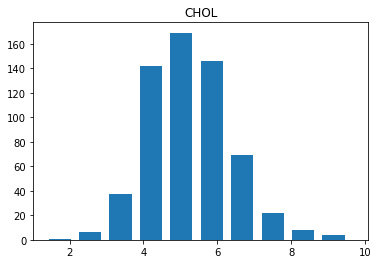

In [15]:
_ = pd.DataFrame.hist(data = hcvDataG, column = 'CHOL',  width=0.6, grid=False)

Now divide patients by sex

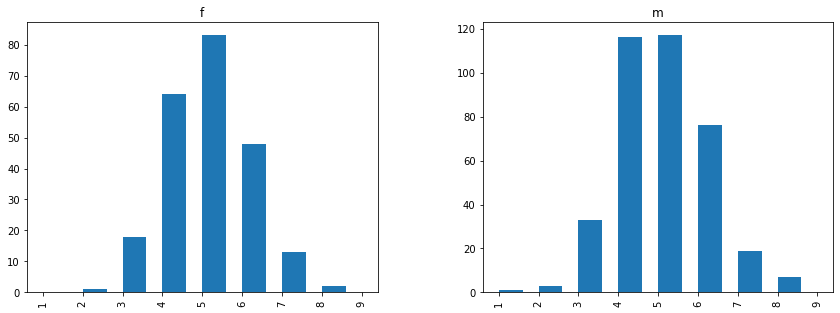

In [18]:
_ = pd.DataFrame.hist(data = hcvDataG, column = 'CHOL', by='Sex', figsize=(14,5), bins=range(1, 10), width=0.6)

**Let's repeat the same with bilirubin (BIL)**

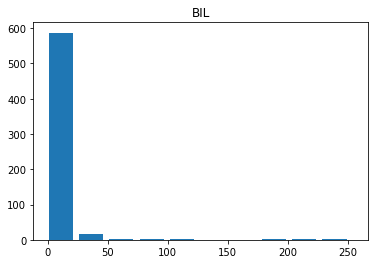

In [19]:
_ = pd.DataFrame.hist(data = hcvDataG, column = 'BIL', grid = False, width=20)

**And now divide patients by Sex.**

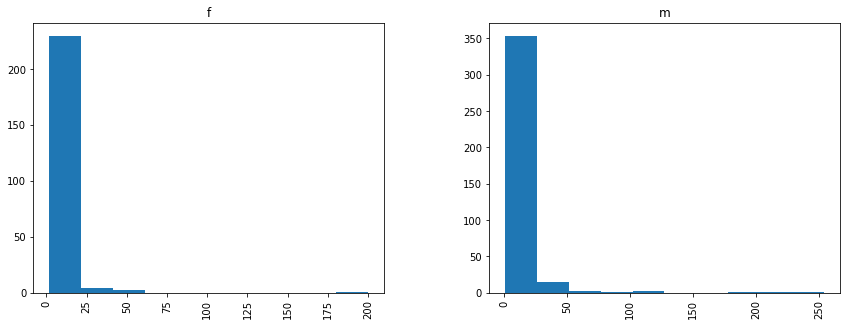

In [20]:
_ = pd.DataFrame.hist(data = hcvDataG, column = 'BIL', by='Sex', figsize=(14,5))

**Try to do the same wit albumin (ALB) dividing patients by Category**

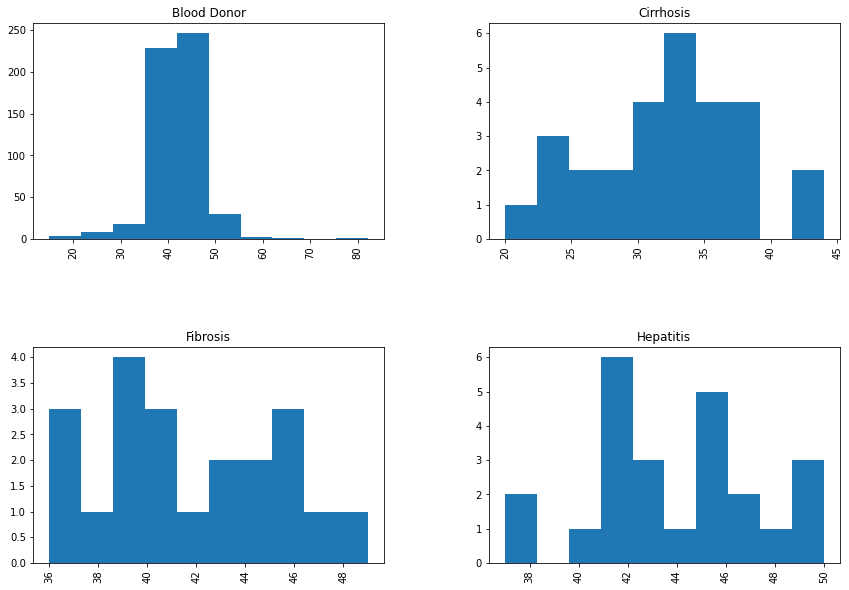

In [21]:
_ = pd.DataFrame.hist(data = hcvDataG, column = 'ALB', by='Category', layout=(2,2), figsize=(14,10))

# Statistical tests for continuous variables

![statistical tests](tests_continuous.jpg)

**From now on, we will use scipy.stats module a lot, so it is good to take a look at [its documentation](https://docs.scipy.org/doc/scipy/reference/stats.html).**

## Normality of distribution

**Check if age of patients is normally distributed in our dataset**

H<sub>0</sub> for Shapiro-Wilk test is "distribution in population is normal".

In [23]:
s, p = stats.shapiro(hcvDataG.loc[:, 'Age'])
print('test statistics: {0:.4f}'.format(s))
print('p-value: {0:.10f}'.format(p))

test statistics: 0.9841
p-value: 0.0000030629


**Repeat the test grouping patients by Sex**

In [24]:
hcvDataG_by_sex = hcvDataG.groupby('Sex')

for group in hcvDataG_by_sex:
    groupName = group[0]
    groupData = hcvDataG_by_sex.get_group(groupName)
    
    s, p = stats.shapiro(groupData.loc[:, 'Age'])
    
    print('Group: {0:s}'.format(groupName))
    print('  test statistics: {0:.4f}'.format(s))
    print('  p-value: {0:.4f}'.format(p))
    print()

Group: f
  test statistics: 0.9758
  p-value: 0.0004

Group: m
  test statistics: 0.9820
  p-value: 0.0001



**Now let's check albumin (ALB), alkaline phosphatase (ALP) and cholesterol (CHOL), dividing patients by Sex**

In [25]:
hcvDataG_by_sex = hcvDataG.groupby('Sex')
variablesForAnalysis = ['ALB', 'ALP', 'CHOL', 'CREA']

for variable in variablesForAnalysis:
    print(variable)
    for group in hcvDataG_by_sex:
        groupName = group[0]
        groupData = hcvDataG_by_sex.get_group(groupName)

        s, p = stats.shapiro(groupData.loc[:, variable].dropna())

        print('  Group: {0:s}'.format(str(groupName)))
        print('    test statistics: {0:.4f}'.format(s))
        print('    p-value: {0:.4f}'.format(p))
        
    print()

ALB
  Group: f
    test statistics: 0.9629
    p-value: 0.0000
  Group: m
    test statistics: 0.8885
    p-value: 0.0000

ALP
  Group: f
    test statistics: 0.8840
    p-value: 0.0000
  Group: m
    test statistics: 0.9835
    p-value: 0.0003

CHOL
  Group: f
    test statistics: 0.9899
    p-value: 0.1069
  Group: m
    test statistics: 0.9873
    p-value: 0.0024

CREA
  Group: f
    test statistics: 0.3197
    p-value: 0.0000
  Group: m
    test statistics: 0.2070
    p-value: 0.0000



**Can you repeat it for creatinine (CREA) and total protein (PROT), grouping patients by Category?**

Try also counting how many values (remember to exclude missing data!) you have in each group.

In [26]:
hcvDataG_by_cat = hcvDataG.groupby('Category')
variablesForAnalysis = ['CREA', 'PROT']

for variable in variablesForAnalysis:
    print(variable)
    for group in hcvDataG_by_cat:
        groupName = group[0]
        groupData = hcvDataG_by_cat.get_group(groupName)
        
        dataNoNa = groupData.loc[:, variable].dropna()
        s, p = stats.shapiro(dataNoNa)

        print('  Group: {0:s}'.format(str(groupName)))
        print('    Number of cases {0:d}'.format(dataNoNa.shape[0]))
        print('    test statistics: {0:.4f}'.format(s))
        print('    p-value: {0:.4f}'.format(p))
        print()
        
    print()


CREA
  Group: Blood Donor
    Number of cases 540
    test statistics: 0.9687
    p-value: 0.0000

  Group: Cirrhosis
    Number of cases 29
    test statistics: 0.4432
    p-value: 0.0000

  Group: Fibrosis
    Number of cases 21
    test statistics: 0.9102
    p-value: 0.0553

  Group: Hepatitis
    Number of cases 24
    test statistics: 0.8030
    p-value: 0.0003


PROT
  Group: Blood Donor
    Number of cases 540
    test statistics: 0.9291
    p-value: 0.0000

  Group: Cirrhosis
    Number of cases 28
    test statistics: 0.9581
    p-value: 0.3147

  Group: Fibrosis
    Number of cases 21
    test statistics: 0.9550
    p-value: 0.4215

  Group: Hepatitis
    Number of cases 24
    test statistics: 0.9517
    p-value: 0.2948




## Difference between 2 independent groups

**Compare ALP between healthy and ill people. Who has higher ALP?**

Let's first calculate descriptive statistics.

In [27]:
hcvDataG.loc[:, ['ALP', 'Healthy']].groupby('Healthy').describe()

ALP                                                         
           count    mean     std     min     25%     50%     75%      max
Healthy                                                                  
NO       56.0000 56.4143 35.7802 11.3000 34.3250 41.0000 75.1000 190.7000
YES     540.0000 68.8698 19.4527 27.0000 55.3000 66.9500 80.1250 208.2000

Now, check the assumption for t-test:
* normality of distribution in both groups
* homogeneity of variance (basically equal variance in both groups)

We'll start with normality of distribution.

In [28]:
hcvDataG_by_health = hcvDataG.groupby('Healthy')

for group in hcvDataG_by_health:
    groupName = group[0]
    groupData = hcvDataG_by_health.get_group(groupName)
    
    s, p = stats.shapiro(groupData.loc[:, 'ALP'].dropna())
    
    print('Group: {0:s}'.format(groupName))
    print('  test statistics: {0:.4f}'.format(s))
    print('  p-value: {0:.4f}'.format(p))
    print()

Group: NO
  test statistics: 0.8271
  p-value: 0.0000

Group: YES
  test statistics: 0.9443
  p-value: 0.0000



Let's try logarithm of ALP

In [29]:
hcvDataG_by_health = hcvDataG.groupby('Healthy')

for group in hcvDataG_by_health:
    groupName = group[0]
    groupData = hcvDataG_by_health.get_group(groupName)
    
    s, p = stats.shapiro(np.log(groupData.loc[:, 'ALP'].dropna()))
    
    print('Group: {0:s}'.format(groupName))
    print('  test statistics: {0:.4f}'.format(s))
    print('  p-value: {0:.4f}'.format(p))
    print()

Group: NO
  test statistics: 0.9625
  p-value: 0.0794

Group: YES
  test statistics: 0.9958
  p-value: 0.1571



Now, it's fine, we can move to the next assumption - equal variances.

But before, let's add log ALP as a new variable to our data frame, we will need it.

In [30]:
hcvDataG.loc[:, 'log ALP'] = np.log(hcvDataG.loc[:, 'ALP'] )

In [31]:
hcvDataG_by_health = hcvDataG.groupby('Healthy')
  
hcvDataG_healthy_ALP = hcvDataG_by_health.get_group('YES').loc[:, 'log ALP'].dropna()
hcvDataG_ill_ALP = hcvDataG_by_health.get_group('NO').loc[:, 'log ALP'].dropna()

s, p = stats.bartlett(hcvDataG_healthy_ALP, hcvDataG_ill_ALP)

print('test statistics: {0:.4f}'.format(s))
print('p-value: {0:.4f}'.format(p))
print()

test statistics: 74.6121
p-value: 0.0000



Second assumption is not met, so let's check the difference with Mann-Whitney test.

In [32]:
s, p = stats.mannwhitneyu(hcvDataG_healthy_ALP, hcvDataG_ill_ALP, use_continuity = True, alternative='two-sided')

print('Mann-Whitney test for ALP in healthy and ill people')
print('  test statistics: {0:.4f}'.format(s))
print('  p-value: {0:.4f}'.format(p))

Mann-Whitney test for ALP in healthy and ill people
  test statistics: 21435.5000
  p-value: 0.0000


Would the conclusion change if we didn't use log-transform?

In [33]:
hcvDataG_healthy_ALP_noLog = hcvDataG_by_health.get_group('YES').loc[:, 'ALP'].dropna()
hcvDataG_ill_ALP_noLog = hcvDataG_by_health.get_group('NO').loc[:, 'ALP'].dropna()

s, p = stats.mannwhitneyu(hcvDataG_healthy_ALP_noLog, hcvDataG_ill_ALP_noLog, 
        use_continuity = True, alternative='two-sided')

print('Mann-Whitney test for ALP in healthy and ill people')
print('  test statistics: {0:.4f}'.format(s))
print('  p-value: {0:.4f}'.format(p))

Mann-Whitney test for ALP in healthy and ill people
  test statistics: 21435.5000
  p-value: 0.0000


**It's exactly the same. Why?**

**And finally, let's see who has higher ALP.**

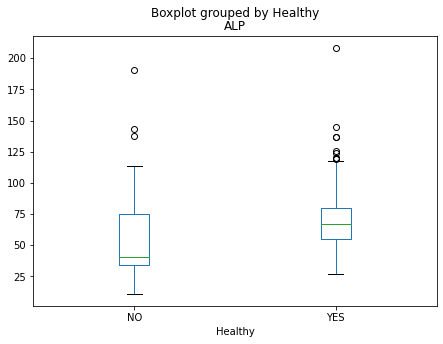

In [34]:
_ = hcvDataG.boxplot(column = 'ALP', by='Healthy', figsize=(7,5), grid=False)

**Would the conclusion change if we used t-test instead?**

In [36]:
s, p = stats.ttest_ind(hcvDataG_healthy_ALP, hcvDataG_ill_ALP, nan_policy='omit')

print('t-test for ALP in healthy and ill people')
print('  test statistics: {0:.4f}'.format(s))
print('  p-value: {0:.4f}'.format(p))

t-test for ALP in healthy and ill people
  test statistics: 7.3932
  p-value: 0.0000


In [37]:
s, p = stats.ttest_ind(hcvDataG_healthy_ALP_noLog, hcvDataG_ill_ALP_noLog, nan_policy='omit')

print('t-test for log(ALP) in healthy and ill people')
print('  test statistics: {0:.4f}'.format(s))
print('  p-value: {0:.4f}'.format(p))

t-test for log(ALP) in healthy and ill people
  test statistics: 4.1281
  p-value: 0.0000


**More correct option would be to use Welch test, which is just t-test modified so that it can accommodate unequal variances**

Let's do it on log-transformed data.

In [38]:
s, p = stats.ttest_ind(hcvDataG_healthy_ALP, hcvDataG_ill_ALP, nan_policy='omit', equal_var=False)

print('t-test for ALP in healthy and ill people')
print('  test statistics: {0:.4f}'.format(s))
print('  p-value: {0:.4f}'.format(p))

t-test for ALP in healthy and ill people
  test statistics: 4.2645
  p-value: 0.0001


**Try to modify the code above to:**
* Compare bilirubin between men and women
* Compare white blood cells between healthy and ill people

## Differences between 3 or more independent groups

**Check if patients in different groups (Category) have different albumin (ALB)**

Start by verification of assumptions for ANOVA

In [39]:
hcvDataG_by_cat = hcvDataG.groupby('Category')
varName = 'ALB'

for group in hcvDataG_by_cat:
    groupName = group[0]
    groupData = hcvDataG_by_cat.get_group(groupName)
    
    s, p = stats.shapiro(groupData.loc[:, varName].dropna())
    
    print('Group: {0:s}'.format(groupName))
    print('  test statistics: {0:.4f}'.format(s))
    print('  p-value: {0:.4f}'.format(p))
    print()

Group: Blood Donor
  test statistics: 0.9192
  p-value: 0.0000

Group: Cirrhosis
  test statistics: 0.9795
  p-value: 0.8386

Group: Fibrosis
  test statistics: 0.9532
  p-value: 0.3901

Group: Hepatitis
  test statistics: 0.9689
  p-value: 0.6398



Normality assumption is not met, so let's use Kruskal-Wallis test to compare the groups.

In [40]:
hcvDonors = hcvDataG_by_cat.get_group('Blood Donor').loc[:, varName]
hcvCirrhosis = hcvDataG_by_cat.get_group('Cirrhosis').loc[:, varName]
hcvFibrosis = hcvDataG_by_cat.get_group('Fibrosis').loc[:, varName]
hcvHepatitis = hcvDataG_by_cat.get_group('Hepatitis').loc[:, varName]

s, p = stats.kruskal(hcvDonors, hcvCirrhosis, hcvFibrosis, hcvHepatitis, nan_policy = 'omit')

print('test statistics: {0:.4f}'.format(s))
print('p-value: {0:.4f}'.format(p))

test statistics: 55.2929
p-value: 0.0000


**Which pairs of groups differ?**

In [41]:
post_hoc_results = posthocs.posthoc_dunn(hcvDataG, val_col = varName, group_col = 'Category')
post_hoc_results

,Blood Donor,Cirrhosis,Fibrosis,Hepatitis
Blood Donor,-1.0000,0.0000,0.6473,0.0528
Cirrhosis,0.0000,-1.0000,0.0000,0.0000
Fibrosis,0.6473,0.0000,-1.0000,0.0905
Hepatitis,0.0528,0.0000,0.0905,-1.0000


Finally, let's look at the differences

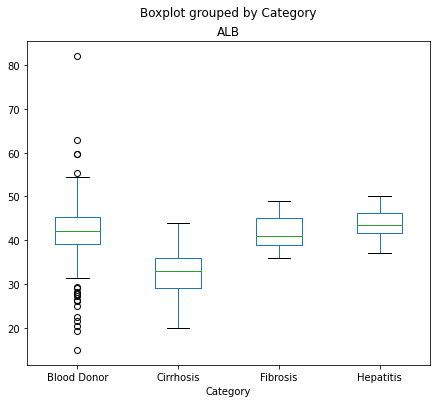

In [42]:
_ = hcvDataG.boxplot(column = varName, by='Category', figsize=(7,6), grid=False)

**What would happen with ANOVA applied to the task?**

In [43]:
s, p = stats.f_oneway(
    hcvDonors.dropna(),
    hcvCirrhosis.dropna(),
    hcvFibrosis.dropna(),
    hcvHepatitis.dropna(),
)

print('test statistics: {0:.4f}'.format(s))
print('p-value: {0:.4f}'.format(p))

test statistics: 28.7237
p-value: 0.0000


In [44]:
post_hoc_results = posthocs.posthoc_tukey(hcvDataG, val_col=varName, group_col='Category')
post_hoc_results

,Blood Donor,Hepatitis,Fibrosis,Cirrhosis
Blood Donor,-1.0000,0.3709,0.9000,0.0010
Hepatitis,0.3709,-1.0000,0.5670,0.0010
Fibrosis,0.9000,0.5670,-1.0000,0.0010
Cirrhosis,0.0010,0.0010,0.0010,-1.0000


**If you want to practice more:**
* Repeat the analysis for red blood cells (RBC).
* Try modifying the code so that you can get analysis for more than one variable at the same time.

## Differences between 2 dependent groups

**Now, we will move to the second (Egyptian) dataset.**

**Check is amount of viral RNA changed between the baseline (RNA Base) and end of treatment (RNA EOT)**

Start checking assumptions of parametric (t-test for related/dependent).

In [ ]:
varNames = ['RNA Base', 'RNA EOT']
hcvRNA = hcvDataE.loc[:, varNames].dropna(axis='index', how='any')

In [ ]:
for varName in varNames:
    s, p = stats.shapiro(hcvRNA.loc[:, varName])

    print('Group: {0:s}'.format(varName))
    print('  test statistics: {0:.4f}'.format(s))
    print('  p-value: {0:.4f}'.format(p))
    print()

At this point, you can check if logarithmic transformation of values makes distribution normal (but here it doesn't).

To analyze the changes in viral RNA, we will use non-parametric test: Wilcoxon test.

In [ ]:
s, p = stats.wilcoxon(hcvRNA.loc[:, 'RNA Base'], hcvRNA.loc[:, 'RNA EOT'])

print('test statistics: {0:.4f}'.format(s))
print('p-value: {0:.4f}'.format(p))

Amount of viral DNA changes during treatment, so try to visualize it.

In [ ]:
_ = hcvRNA.boxplot(column = varNames, figsize=(7,5), grid=False)

**What if we used t-test instead?**

In [ ]:
s, p = stats.ttest_rel(hcvRNA.loc[:, 'RNA Base'], hcvRNA.loc[:, 'RNA EOT'])

print('test statistics: {0:.4f}'.format(s))
print('p-value: {0:.4f}'.format(p))

## Differences between 3 or more related measurements

**Analyze changes in amounts viral RNA along the treatment**

We check normality of distribution at baseline at and at the end of treatment, so we know that assumptions for ANOVA are not met. We can move directly to Friedman test.

In [ ]:
varNames = ['RNA Base', 'RNA 4', 'RNA 12', 'RNA EOT']
hcvRNA = hcvDataE.loc[:, varNames].dropna(axis='index', how='any')

In [ ]:
s, p = stats.friedmanchisquare(
    hcvRNA.loc[:, 'RNA Base'],
    hcvRNA.loc[:, 'RNA 4'],
    hcvRNA.loc[:, 'RNA 12'],
    hcvRNA.loc[:, 'RNA EOT'],
)

print('test statistics: {0:.4f}'.format(s))
print('p-value: {0:.4f}'.format(p))

In [ ]:
post_hoc_results = posthocs.posthoc_nemenyi_friedman(hcvRNA, y_col=varNames)
post_hoc_results.loc[varNames, varNames]

In [ ]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
_ = hcvRNA.boxplot(column = varNames, ax=ax, grid=False)
_ = ax.set_ylim(top=15*10**5)

**Let's try another option of visualization, so calles cases' profiles**

First, we transform our array, so that one column contains patient's IDs, other timepoints and the last amount of RNA.

In [ ]:
hcvRNA.loc[:, 'Patient'] = hcvRNA.index
hcvRNAmelted = pd.melt(hcvRNA, id_vars = 'Patient', value_vars = varNames, var_name = 'Timepoint', value_name = 'RNA')
hcvRNAmelted

Let's plot the profiles for 10 random patients.

In [ ]:
nPatients = 10
patientIDs = np.unique(hcvRNAmelted['Patient'])
selectedPatientIds = np.random.choice(patientIDs, size=nPatients, replace=False)

selectedRows = [id in list(selectedPatientIds) for id in hcvRNAmelted['Patient']]

hcvRNAmelted_some_patients = hcvRNAmelted.loc[selectedRows,:]
hcvRNAmelted_some_patients

ax = sns.pointplot(data=hcvRNAmelted_some_patients, x='Timepoint', y='RNA', hue='Patient', palette='colorblind',
                  legend=False)
ax.get_legend().remove()

**Would the conclusion change if we applied ANOVA for repeated measurements?**

In [ ]:
anova_rm_rna = AnovaRM(hcvRNAmelted, depvar = 'RNA', subject = 'Patient', within = ['Timepoint'])
anova_rm_rna_res = anova_rm_rna.fit()

print(anova_rm_rna_res)

In [ ]:
post_hoc_res = pairwise_tukeyhsd(hcvRNAmelted.loc[:, 'RNA'], groups = hcvRNAmelted.loc[:, 'Timepoint'])
post_hoc_res.summary()

# Correlations

**Go back to German data set.**
**Check if following laboratory measurements are correlated:**
* ALB
* ALP
* BIL
* PROT

In [ ]:
varNames = ['ALB', 'ALP', 'BIL', 'PROT']
hcvLab = hcvDataG.loc[:, varNames]
display(hcvLab)

In [ ]:
hcvLab.corr(method='spearman')

In [ ]:
hcvLab.corr(method='pearson')

**If you want also p-values, you need scipy**

In [ ]:
r, p = stats.spearmanr(hcvLab, nan_policy='omit')

display(pd.DataFrame(r, index=varNames, columns=varNames))

display(pd.DataFrame(p, index=varNames, columns=varNames))

But the same doesn't work with Pearson correlation, because it doesn't take 2D array and neither it has omit_nan :(.

In [ ]:
r = pd.DataFrame(np.zeros([len(varNames),len(varNames)]), columns=varNames, index=varNames)
p = pd.DataFrame(np.zeros([len(varNames),len(varNames)]), columns=varNames, index=varNames)

for comb in itertools.combinations(varNames, r=2):
    names = list(comb)
    name1 = names[0]
    name2 = names[1]
    hcvLabCurrent = hcvLab.loc[:, [name1, name2]].dropna()
    cr, cp = stats.pearsonr(hcvLabCurrent.loc[:, name1], hcvLabCurrent.loc[:, name2])
    r.loc[name1, name2] = r.loc[name2, name1] = cr
    p.loc[name1, name2] = p.loc[name2, name1] = cp

display(r)

display(p)

Let's visualize the correlation ALB and ALP

In [ ]:
_ = hcvLab.plot.scatter(x='ALB', y='PROT')

Let's look at all correlations at once

In [ ]:
_ = sns.pairplot(hcvLab)

For training, repeat this type of analysis for viral RNA variables in Egyptian dataset. Don't forget the plots.

Can you tell what is wrong in that analysis? (Hint: beware of outliers).

# Statistical tests for nominal variables

**Using Egyptian dataset, check if Nausea/Vomiting is equally common in patients with and without Epigastric pain**

We start creating contingency table.

In [ ]:
table1 = pd.crosstab(hcvDataE['Epigastric pain'], hcvDataE['Nausea/Vomiting'])
table1

For readability, we can calculate percentages in rows and columns (but the tests won't need them).

In [ ]:
table1_percent_rows = table1.apply(lambda r: r/r.sum()*100, axis=1)
table1_percent_rows

In [ ]:
table1_percent_cols = table1.apply(lambda r: r/r.sum()*100, axis=0)
table1_percent_cols

In [ ]:
s, p, _, _ = stats.chi2_contingency(table1, correction=False)
OR, pf = stats.fisher_exact(table1)
print('p-value from chi-square test: {0:.04f}:'.format(p))
print('p-value from Fisher exact test: {0:.04f}'.format(pf))

**Now, check if presence of Epigastric pain is related to Baseline histological staging**

In [ ]:
table2 = pd.crosstab(hcvDataE['Baseline histological staging'], hcvDataE['Epigastric pain'])
display(table2)
s, p, _, _ = stats.chi2_contingency(table2)
print('p-value from chi-square test: {0:.4f}'.format(p))

**Can you add percentages on your own?**

In [ ]:
table2_percent_rows = table2.apply(lambda r: r/r.sum()*100, axis=1)
table2_percent_rows

In [ ]:
table2_percent_cols = table2.apply(lambda r: r/r.sum()*100, axis=0)
table2_percent_cols

# Multiple testing

**At the beginning, we need to read the last dataset.**

By the way, it comes from our [article](https://www.mdpi.com/2072-6694/12/6/1525/htm).

**It is organized in a different way that previous two:**
* variables are in rows.
* cases in columns.

Variables are expression values for >20k rat's genes. They were measured by hybridization microarrays and here are already log-transformed.

Cases are 12 rats:
* 3 healthy (wild type).
* 3 with heterozygous knock-out of TP53 (they have only one correct copy, instead of 2).
* 3 with homozygous knock-out of TP53 (they have no normal copy of TP53 gene).
* 3 with homozygous knock-out of TP53 that have already developed sarcoma.

Our task is to compare expression of all genes between 3 groups. We will perform >20k test, so we really need multiple comparison corrections.

Let's look at data!

In [ ]:
if IN_COLAB:
    fname = 'https://raw.githubusercontent.com/UlaSmycz/NGSeminar_biostatistics/master/rats_ngseminar.csv'
else:
    fname = 'rats_ngseminar.csv'

ratsData = pd.read_csv(fname, sep=';', index_col=0, header=[0,1])

In [ ]:
display(ratsData)

**Group the rats and calculate mean expression of each gene per group.**

In [ ]:
ratsDataGrouped = ratsData.groupby(level=['Group'], axis=1)
ratsDataResults = ratsDataGrouped.apply(np.mean, axis=1) 
display(ratsDataResults)

**Now compare the groups by ANOVA**

Here, we omit assumption verification, because it wouldn't be reliable with 3 samples per group. Additionally, with so few samples non-parametric test wouldn't be very effective too (but you can easily substitute test and check why).

In [ ]:
healthy = ratsDataGrouped.get_group('healthy')
het = ratsDataGrouped.get_group('ko')
ko = ratsDataGrouped.get_group('het')
sarcoma = ratsDataGrouped.get_group('sarcoma')

s, p = stats.f_oneway(healthy, ko, het, sarcoma, axis=1)

ratsDataResults.loc[:, 'p'] = p

display(ratsDataResults.sort_values(by='p'))

**How many p-values below 0.05 do we have?**

In [ ]:
sigP = (ratsDataResults.loc[:, 'p']<0.05).sum()
sigP_percent = sigP/ratsDataResults.shape[0]*100

print('Number of p-values below 0.05: {0:d}'.format(sigP))
print('It is {0:.1f}% of all genes.'.format(sigP_percent))

**Let's apply FDR and FWER correction**

In [ ]:
fdr = multipletests(ratsDataResults.loc[:, 'p'], alpha=0.05, method='fdr_bh')
ratsDataResults['FDR'] = fdr[1]

In [ ]:
fwer = multipletests(ratsDataResults.loc[:, 'p'], alpha=0.05, method='bonferroni')
ratsDataResults['FWER'] = fwer[1]

In [ ]:
display(ratsDataResults)

In [ ]:
sigFDR = (ratsDataResults.loc[:, 'FDR']<0.05).sum()
sigFDR_percent = sigFDR/ratsDataResults.shape[0]*100

print('Number of FDR-corrected p-values below 0.05: {0:d}'.format(sigFDR))
print('It is {0:.1f}% of all genes.'.format(sigFDR_percent))

sigFWER = (ratsDataResults.loc[:, 'FWER']<0.05).sum()
sigFWER_percent = sigFWER/ratsDataResults.shape[0]*100

print()
print('Number of FWER-corrected p-values below 0.05: {0:d}'.format(sigFWER))
print('It is {0:.1f}% of all genes.'.format(sigFWER_percent))